In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency, norm, ttest_rel
from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

Тут у нас основная часть проекта. Работаем с данными, выковыриваем показатели, проверяем ряд гипотез и, конечно, строим модельку. По парсингу - смотрите другие блокноты.

<center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ0xvQwAuxG3zLzFggzkt24lcWf6RRQkKRVDA&s" width="200"></center>

In [2]:
important_columns = ['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY',
       'AY', 'HR', 'AR', 'MaxH', 'MaxD', 'MaxA']
columns_to_rename = {
    'Date': 'date',
    'Time': 'time',
    'HomeTeam': 'home_team',
    'AwayTeam': 'away_team',
    'FTHG': 'full_time_home_goals',
    'FTAG': 'full_time_away_goals',
    'FTR': 'full_time_result',
    'HTHG': 'first_half_home_goals',
    'HTAG': 'first_half_away_goals',
    'HTR': 'first_half_result',
    'HS': 'home_shots',
    'AS': 'away_shots',
    'HST': 'home_target_shots',
    'AST': 'away_target_shots',
    'HF': 'fouls_home',
    'AF': 'fouls_away',
    'HC': 'corners_home',
    'AC': 'corners_away',
    'HY': 'yellow_cards_home',
    'AY': 'yellow_cards_away',
    'HR': 'red_cards_home',
    'AR': 'red_cards_away',
    'MaxH': 'max_odds_home_win',
    'MaxD': 'max_odds_draw',
    'MaxA': 'maximum_odds_away_win'
}


Кажется, тут и так всё понятно. Но на всякий случай распишем.    
    
  'date', - дата матча  
  'time', - время матча  
  'home_team', - хозяева (хотя бы формально)  
  'away_team', - гости  
  'full_time_home_goals', - количество голов хозяев  
  'full_time_away_goals', - количество голов гостей  
  'full_time_result', - результат матча (H - хозяева, A - гости, D - ничья)  
  'first_half_home_goals', - количество голов хозяев в первом тайме  
  'first_half_away_goals', - количество голов гостей в первом тайме  
  'first_half_result', - результат первого тайма  
  'home_shots', - количество ударов хозяев  
  'away_shots', - количество ударов гостей  
  'home_target_shots', - количество ударов в створ хозяев  
  'away_target_shots', - количество ударов в створ гостей  
  'fouls_home', - количество фолов хозяев  
  'fouls_away', - количество фолов гостей  
  'corners_home', - количество угловых хозяев (которые они разыгрывали)  
  'corners_away', - количество угловых гостей  
  'yellow_cards_home', - количество желтых карточек хозяев   
  'yellow_cards_away', - количество желтых карточек гостей  
  'red_cards_home', - количество красных карточек хозяев  
  'red_cards_away', - количество красных карточек гостей  
  'max_odds_home_win', - наибольший коэффициент, который букмеры предлагали за предсказание победы хозяев  
  'max_odds_draw', наибольший коэффициент, который букмеры предлагали за предсказание ничьи  
  'maximum_odds_away_win' - наибольший коэффициент, который букмеры предлагали за предсказание победы гостей  

In [3]:
def five_years_ligue_history(ligue_urls):
    """создает датасет с данными из конкретной футбольной лиги"""

    five_years_history = pd.DataFrame()
    for url in ligue_urls:
        ligue_data = pd.read_csv(url, sep=',')

        ligue_important_data = ligue_data[important_columns]

        five_years_history = pd.concat([five_years_history, ligue_important_data], axis=0)

    five_years_history.reset_index(inplace=True, drop=True)
    five_years_history.rename(columns=columns_to_rename, inplace=True)
    five_years_history['date'] = pd.to_datetime(five_years_history['date'], format="%d/%m/%Y")

    return five_years_history

In [4]:
def find_2clubs_confr_history(some_data, club1, club2):
    """ищет историю игр между двумя клубами"""
    history = some_data[((some_data['home_team'] == club1) & (some_data['away_team'] == club2)) |
        ((some_data['home_team'] == club2) & (some_data['away_team'] == club1))]
    history.reset_index(drop=True, inplace=True)
    return history

In [5]:
def find_club_match_history(some_data, club):
    """ищет историю игр конкретного клуба"""

    history = some_data[(some_data['home_team'] == club) | (some_data['away_team'] == club)]
    history.reset_index(drop=True, inplace=True)
    return history

In [6]:
def find_avg_points_history(some_data, club):
    """ищет среднее количество очков клуба"""


    history = find_club_match_history(some_data, club)
    sum_points = len(history[(history['home_team'] == club) & (history['full_time_result'] == 'H')]) * 3 \
        + len(history[(history['away_team'] == club) & (history['full_time_result'] == 'A')]) * 3 \
        + len(history[(history['home_team'] == club) & (history['full_time_result'] == 'D')]) \
        + len(history[(history['away_team'] == club) & (history['full_time_result'] == 'D')])

    return sum_points / len(history)


In [7]:
def first_and_last_time_results(some_data, club):
    """сравнивает количество голов за первый тайм и за второй (или насколько клуб играет лучше во втором тайме)"""

    history = find_club_match_history(some_data, club)

    avg_first_time = (history[history['home_team'] == club]['first_half_home_goals'].sum() \
                      + history[history['away_team'] == club]['first_half_away_goals'].sum()) / len(history)


    avg_last_time = (history[history['home_team'] == club]['full_time_home_goals'].sum() \
                      + history[history['away_team'] == club]['full_time_away_goals'].sum()) / len(history) - avg_first_time

    return avg_first_time, avg_last_time

In [8]:
def compare_home_away_fouls_cards_ratio(some_data):
    """ищет предвзятость судей на домашнем стадионе в лиге и возвращает соотношение фолов и карточек для домашней и гостевой команд"""

    fouls_home = some_data['fouls_home'].sum()
    fouls_away = some_data['fouls_away'].sum()

    cards_home = (some_data['yellow_cards_home'] + some_data['red_cards_home']).sum()
    cards_away = (some_data['yellow_cards_away'] + some_data['red_cards_away']).sum()

    home_ratio = fouls_home / cards_home
    away_ratio = fouls_away / cards_away

    return home_ratio, away_ratio

In [9]:
def find_home_away_goals_ratio(some_data):
    """ищет соотношение ударов и голов для домашних и гостевых команд в заданной лиге"""

    goals_home = some_data['first_half_home_goals'].sum()
    goals_away = some_data['first_half_away_goals'].sum()

    shots_home = some_data['home_target_shots'].sum()
    shots_away = some_data['away_target_shots'].sum()

    home_ratio = shots_home / goals_home
    away_ratio = shots_away / goals_away

    return home_ratio, away_ratio

In [10]:
def realization_ratio(some_data):
    """ищет % реализации ударов по воротам для домашних и гостевых команд в заданной лиге"""

    goals_home = some_data['first_half_home_goals']
    goals_away = some_data['first_half_away_goals']

    shots_home = some_data['home_target_shots']
    shots_away = some_data['away_target_shots']

    shots_home[shots_home == 0] = 1
    shots_away[shots_away == 0] = 1

    home_ratio = goals_home / shots_home
    away_ratio = goals_away / shots_away

    return home_ratio, away_ratio

In [11]:
def find_avg_goals_5_matches(some_data, club_name):
    '''ищет среднее количество голов за 5 матчей для команды'''
    club = find_club_match_history(some_data, club_name)
    club_away_goals = club[club['away_team'] == club_name][['date', 'full_time_away_goals']]
    club_away_goals_ser = club_away_goals['full_time_away_goals']
    club_away_goals_ser.index = club_away_goals['date']


    club_home_goals = club[club['home_team'] == club_name][['date', 'full_time_home_goals']]
    club_home_goals_ser = club_home_goals['full_time_home_goals']
    club_home_goals_ser.index = club_home_goals['date']



    club_data = pd.concat([club_home_goals_ser, club_away_goals_ser])
    club_data = club_data.sort_index()

    mean_5_club = club_data.rolling(window=5, min_periods=5).mean()

    return mean_5_club

In [12]:
def find_results_5_matches(some_data, club_name):
    '''ищет суммарное количество голов и очков за 5 последних матчей'''

    ## ищем все в случае когда команда играет в гостях
    club = find_club_match_history(some_data, club_name)

    club_away_results = club[club['away_team'] == club_name][['date', 'full_time_away_goals', 'full_time_result']]

    club_away_goals_ser = club_away_results['full_time_away_goals']
    club_away_goals_ser.index = club_away_results['date']

    club_away_points_ser = 3 * (club_away_results['full_time_result'] == 'A') + (club_away_results['full_time_result'] == 'D')
    club_away_points_ser.index = club_away_results['date']

    ## ищем все в случае когда команда играет дома
    club_home_results = club[club['home_team'] == club_name][['date', 'full_time_home_goals', 'full_time_result']]

    club_home_goals_ser = club_home_results['full_time_home_goals']
    club_home_goals_ser.index = club_home_results['date']

    club_home_points_ser = 3 * (club_home_results['full_time_result'] == 'H') + (club_home_results['full_time_result'] == 'D')
    club_home_points_ser.index = club_home_results['date']


    club_data_goals = pd.concat([club_home_goals_ser, club_away_goals_ser])
    club_data_goals = club_data_goals.sort_index()

    club_data_points = pd.concat([club_home_points_ser, club_away_points_ser])
    club_data_points = club_data_points.sort_index()

    sum_5_club_goals = club_data_goals.rolling(window=5, min_periods=5).sum()
    sum_5_club_points = club_data_points.rolling(window=5, min_periods=5).sum()

    club_data = pd.concat([sum_5_club_goals, sum_5_club_points], axis=1)
    club_data = club_data.rename(columns={0:"sum_goals_5", "full_time_result": "sum_points_5"})

    return club_data.shift(1), club_data.tail(1) ## данные до последнего матча и данные после последнего матча

In [13]:
def draw_everything(some_df):
    """рисует гистограмму побед хозяев и гостей, гиаграмму рассеяния (голы хозяев vs. голы гостей),
    гистограмму количества голов за матч, гистограмма правильных прогнозов"""
    some_df['match_result'] = some_df.apply(lambda row: 'Home Win' if row['full_time_result'] == 'H'
                                  else ('Away Win' if row['full_time_result'] == 'A'
                                        else 'Draw'), axis=1)

    # 1. Гистограмма побед хозяев и гостей
    win_counts = some_df['match_result'].value_counts()

    plt.figure(figsize=(6, 4))
    win_counts[['Home Win', 'Away Win']].plot(kind='bar', color=['blue', 'red'])
    plt.title("Number of Home and Away Wins")
    plt.xlabel("Match Result")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

    # 2. Диаграмма рассеяния (голы хозяев vs. голы гостей)
    plt.figure(figsize=(6, 6))
    plt.scatter(some_df['full_time_home_goals'], some_df['full_time_away_goals'], alpha=0.6)
    plt.xlabel("Home Team Goals")
    plt.ylabel("Away Team Goals")
    plt.title("Scatter Plot of Home vs. Away Goals")
    plt.grid(True)
    plt.show()

    # 3. Гистограмма количества голов за матч
    match_goals = some_df['full_time_home_goals'] +	some_df['full_time_away_goals']

    plt.figure(figsize=(6, 4))
    plt.hist(match_goals, bins=9,color="skyblue", edgecolor="black")
    plt.xlabel("Amount of Goals")
    plt.ylabel("Frequency")
    plt.title("Summary match goals distribution")




    # 4. Гистограмма правильных прогнозов
    some_df['predicted_result'] = some_df.apply(lambda row: 'Home Win' if row['max_odds_home_win'] < row['max_odds_draw'] and row['max_odds_home_win'] < row['maximum_odds_away_win']
                                          else ('Away Win' if row['maximum_odds_away_win'] < row['max_odds_home_win'] and row['maximum_odds_away_win'] < row['max_odds_draw']
                                                else 'Draw'), axis=1)

    some_df['correct_prediction'] = (some_df['match_result'] == some_df['predicted_result']).astype(int)

    plt.figure(figsize=(6, 4))
    some_df['correct_prediction'].value_counts().sort_index().plot(kind='bar', color=['red', 'green'])
    plt.xticks([0, 1], ['Incorrect', 'Correct'], rotation=0)
    plt.title("Histogram of Correct Predictions Based on Odds")
    plt.xlabel("Prediction Accuracy")
    plt.ylabel("Count")
    plt.show()


    # 5. Гистограмма голов в первом и втором тайме
    first = []
    second = []
    for i in np.unique(some_df['away_team']):
        avg_first_time, avg_last_time = first_and_last_time_results(some_df, i)
        first.append(avg_first_time)
        second.append(avg_last_time)
    x = np.array(first).mean()
    y = np.array(second).mean()
    labels = ['First', 'Second']
    values = [x, y]
    plt.bar(labels, values, color=['blue', 'red'])
    plt.title("Histogram goals in the first and second time")
    plt.xlabel("Time")
    plt.ylabel("Goals")
    plt.show()

    # 6. Распределение среднего количества очков
    points = []
    for i in np.unique(some_df['away_team']):
        points.append(find_avg_points_history(some_df, i))

    plt.figure(figsize=(6, 4))
    plt.hist(points, bins=9,color="skyblue", edgecolor="black")
    plt.xlabel("Average points")
    plt.ylabel("Teams")
    plt.title("Average points distribution")





In [14]:
eng_urls = ['https://www.football-data.co.uk/mmz4281/1920/E0.csv', 'https://www.football-data.co.uk/mmz4281/2021/E0.csv', 'https://www.football-data.co.uk/mmz4281/2122/E0.csv',
            'https://www.football-data.co.uk/mmz4281/2223/E0.csv', 'https://www.football-data.co.uk/mmz4281/2324/E0.csv',
           'https://www.football-data.co.uk/mmz4281/2425/E0.csv']
eng_data = five_years_ligue_history(eng_urls)
eng_data

,date,time,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,first_half_home_goals,first_half_away_goals,first_half_result,...,fouls_away,corners_home,corners_away,yellow_cards_home,yellow_cards_away,red_cards_home,red_cards_away,max_odds_home_win,max_odds_draw,maximum_odds_away_win
0,2019-08-09,20:00,Liverpool,Norwich,4,1,H,4,0,H,...,9,11,2,0,2,0,0,1.16,10.00,23.00
1,2019-08-10,12:30,West Ham,Man City,0,5,A,0,1,A,...,13,1,1,2,2,0,0,13.00,6.75,1.29
2,2019-08-10,15:00,Bournemouth,Sheffield United,1,1,D,0,0,D,...,19,3,4,2,1,0,0,2.06,3.65,4.00
3,2019-08-10,15:00,Burnley,Southampton,3,0,H,0,0,D,...,12,2,7,0,0,0,0,2.80,3.33,2.85
4,2019-08-10,15:00,Crystal Palace,Everton,0,0,D,0,0,D,...,14,6,2,2,1,0,1,3.21,3.40,2.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176,2025-03-08,20:00,Wolves,Everton,1,1,D,1,1,D,...,16,5,5,2,2,0,0,2.71,3.31,2.95
2177,2025-03-09,14:00,Chelsea,Leicester,1,0,H,0,0,D,...,13,12,2,1,0,0,0,1.22,8.40,15.50
2178,2025-03-09,14:00,Tottenham,Bournemouth,2,2,D,0,1,A,...,16,3,6,3,3,0,0,2.79,3.98,2.45
2179,2025-03-09,16:30,Man United,Arsenal,1,1,D,1,0,H,...,11,2,9,0,1,0,0,6.00,3.81,1.75


In [15]:
eng_data.isna().sum()
## пропусков в данных нет

date                     0
time                     0
home_team                0
away_team                0
full_time_home_goals     0
full_time_away_goals     0
full_time_result         0
first_half_home_goals    0
first_half_away_goals    0
first_half_result        0
home_shots               0
away_shots               0
home_target_shots        0
away_target_shots        0
fouls_home               0
fouls_away               0
corners_home             0
corners_away             0
yellow_cards_home        0
yellow_cards_away        0
red_cards_home           0
red_cards_away           0
max_odds_home_win        0
max_odds_draw            0
maximum_odds_away_win    0
dtype: int64

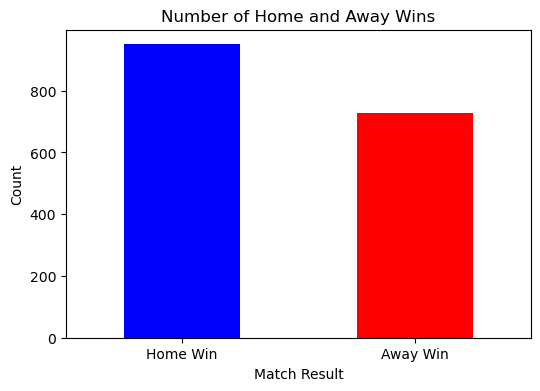

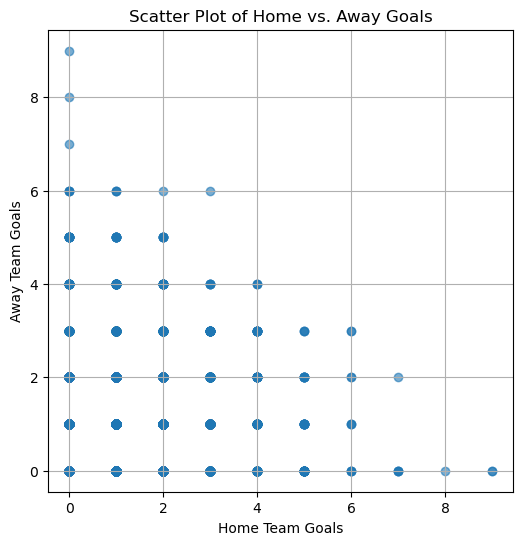

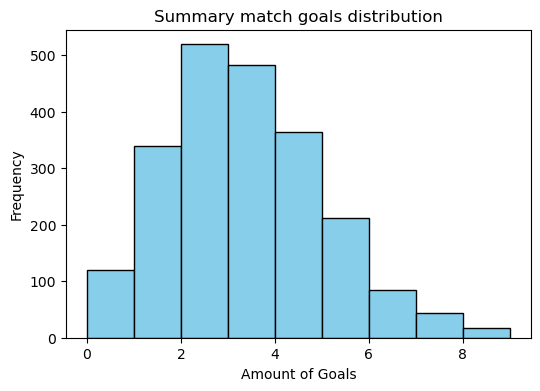

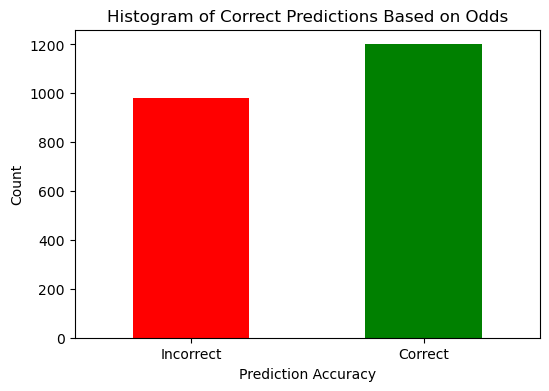

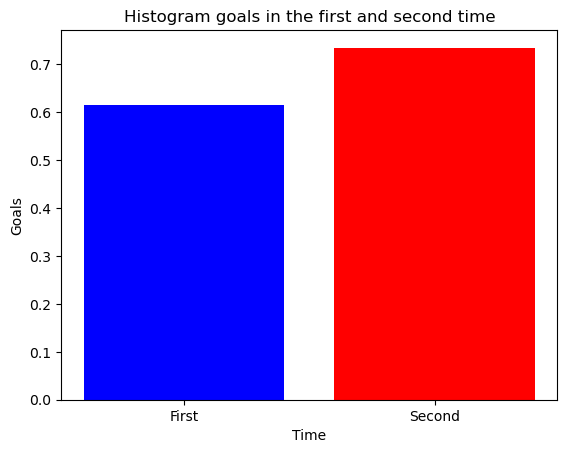

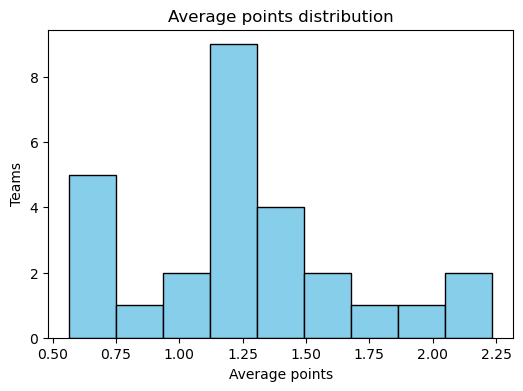

In [16]:
df = eng_data.copy(deep=True)
draw_everything(df)

In [17]:
ger_urls = ['https://www.football-data.co.uk/mmz4281/1920/D1.csv', 'https://www.football-data.co.uk/mmz4281/2021/D1.csv', 'https://www.football-data.co.uk/mmz4281/2122/D1.csv',
           'https://www.football-data.co.uk/mmz4281/2223/D1.csv', 'https://www.football-data.co.uk/mmz4281/2324/D1.csv',
           'https://www.football-data.co.uk/mmz4281/2425/D1.csv']
ger_data = five_years_ligue_history(ger_urls)
ger_data

,date,time,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,first_half_home_goals,first_half_away_goals,first_half_result,...,fouls_away,corners_home,corners_away,yellow_cards_home,yellow_cards_away,red_cards_home,red_cards_away,max_odds_home_win,max_odds_draw,maximum_odds_away_win
0,2019-08-16,19:30,Bayern Munich,Hertha,2,2,D,1,2,A,...,17,12,0,3,3,0,0,1.25,8.30,17.50
1,2019-08-17,14:30,Dortmund,Augsburg,5,1,H,1,1,D,...,6,10,0,0,0,0,0,1.25,7.15,17.00
2,2019-08-17,14:30,Freiburg,Mainz,3,0,H,0,0,D,...,15,5,5,1,3,0,0,2.26,3.49,3.65
3,2019-08-17,14:30,Leverkusen,Paderborn,3,2,H,2,2,D,...,9,6,6,2,0,0,0,1.31,6.40,12.25
4,2019-08-17,14:30,Werder Bremen,Fortuna Dusseldorf,1,3,A,0,1,A,...,13,14,5,0,2,0,0,1.80,4.05,4.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750,2025-03-08,14:30,Leverkusen,Werder Bremen,0,2,A,0,1,A,...,10,10,3,4,4,0,0,1.28,6.80,12.00
1751,2025-03-08,14:30,Wolfsburg,St Pauli,1,1,D,0,1,A,...,13,6,6,1,0,0,0,1.81,3.88,5.00
1752,2025-03-08,17:30,Freiburg,RB Leipzig,0,0,D,0,0,D,...,11,2,6,0,3,0,0,2.67,3.40,2.86
1753,2025-03-09,14:30,Ein Frankfurt,Union Berlin,1,2,A,1,0,H,...,8,1,5,3,0,0,0,1.78,4.22,4.75


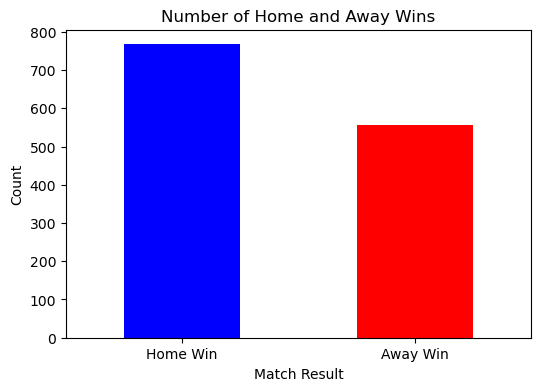

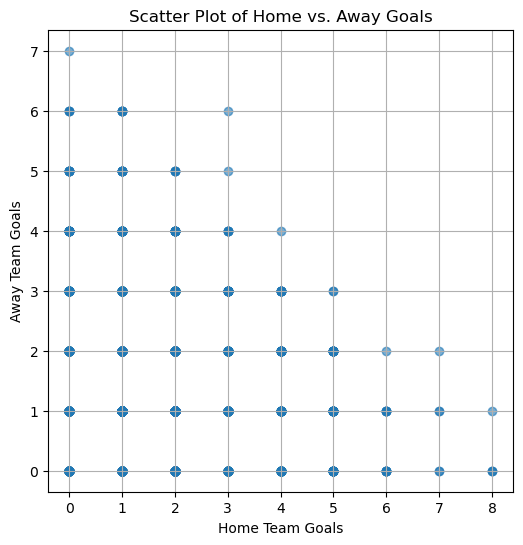

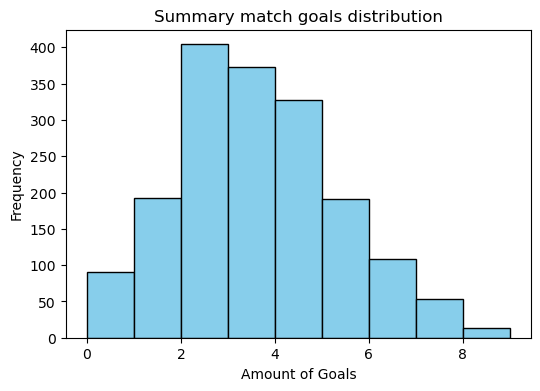

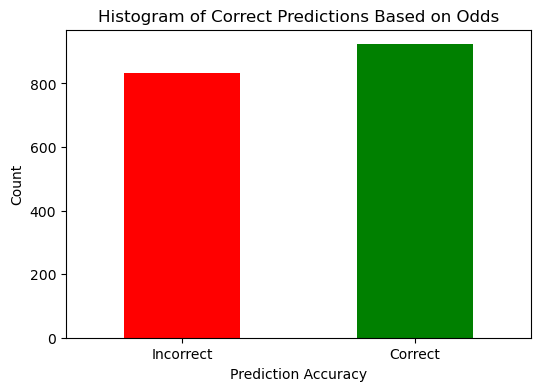

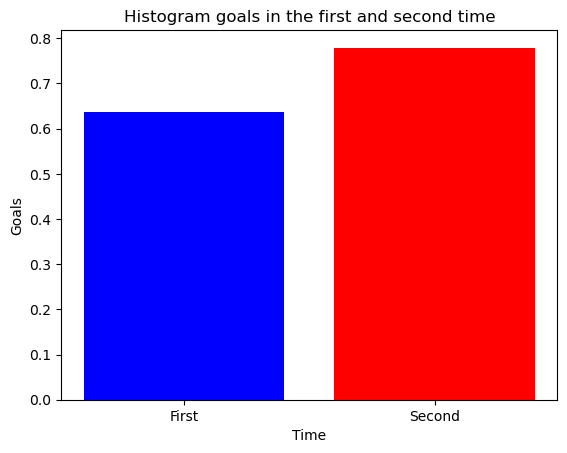

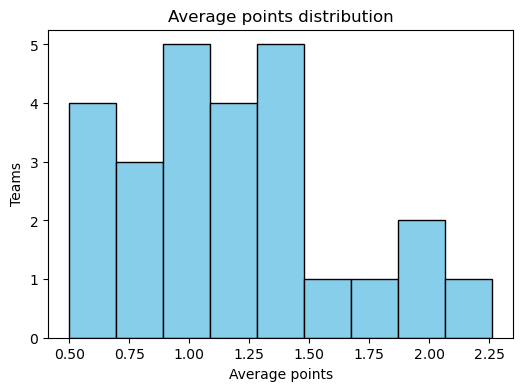

In [18]:
df_1 = ger_data.copy(deep=True)
draw_everything(df_1)

In [19]:
spain_urls = ['https://www.football-data.co.uk/mmz4281/1920/SP1.csv', 'https://www.football-data.co.uk/mmz4281/2021/SP1.csv', 'https://www.football-data.co.uk/mmz4281/2122/SP1.csv',
             'https://www.football-data.co.uk/mmz4281/2223/SP1.csv', 'https://www.football-data.co.uk/mmz4281/2324/SP1.csv',
             'https://www.football-data.co.uk/mmz4281/2425/SP1.csv'
             ]
spain_data = five_years_ligue_history(spain_urls)
spain_data

,date,time,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,first_half_home_goals,first_half_away_goals,first_half_result,...,fouls_away,corners_home,corners_away,yellow_cards_home,yellow_cards_away,red_cards_home,red_cards_away,max_odds_home_win,max_odds_draw,maximum_odds_away_win
0,2019-08-16,20:00,Ath Bilbao,Barcelona,1,0,H,0,0,D,...,9,3,8,1,1,0,0,5.50,3.95,1.76
1,2019-08-17,16:00,Celta,Real Madrid,1,3,A,0,1,A,...,12,6,4,5,2,0,1,5.30,4.40,1.73
2,2019-08-17,18:00,Valencia,Sociedad,1,1,D,0,0,D,...,14,3,3,4,4,1,0,1.72,3.98,5.75
3,2019-08-17,19:00,Mallorca,Eibar,2,1,H,1,0,H,...,14,9,3,2,3,0,0,3.05,3.20,2.70
4,2019-08-17,20:00,Leganes,Osasuna,0,1,A,0,0,D,...,11,8,0,1,4,1,0,2.10,3.30,4.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163,2025-03-09,15:15,Real Madrid,Vallecano,2,1,H,2,1,H,...,17,4,6,3,1,0,0,1.31,6.50,11.00
2164,2025-03-09,17:30,Ath Bilbao,Mallorca,1,1,D,0,0,D,...,13,3,3,1,3,0,0,1.66,3.98,6.50
2165,2025-03-09,17:30,Betis,Las Palmas,1,0,H,0,0,D,...,14,11,1,2,8,0,1,1.48,4.83,7.50
2166,2025-03-09,20:00,Sociedad,Sevilla,0,1,A,0,0,D,...,12,6,3,2,1,0,0,2.30,3.29,3.70


In [20]:
spain_data.isna().sum()
## пропусков в данных нет

date                     0
time                     0
home_team                0
away_team                0
full_time_home_goals     0
full_time_away_goals     0
full_time_result         0
first_half_home_goals    0
first_half_away_goals    0
first_half_result        0
home_shots               0
away_shots               0
home_target_shots        0
away_target_shots        0
fouls_home               0
fouls_away               0
corners_home             0
corners_away             0
yellow_cards_home        0
yellow_cards_away        0
red_cards_home           0
red_cards_away           0
max_odds_home_win        0
max_odds_draw            0
maximum_odds_away_win    0
dtype: int64

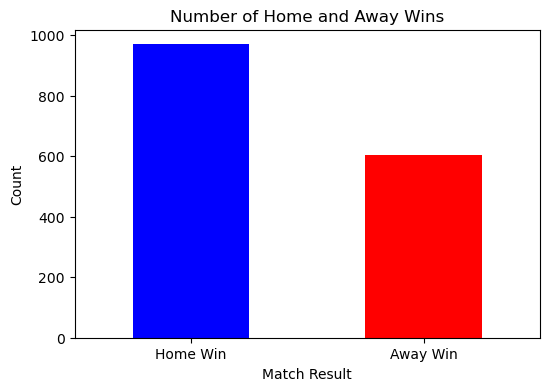

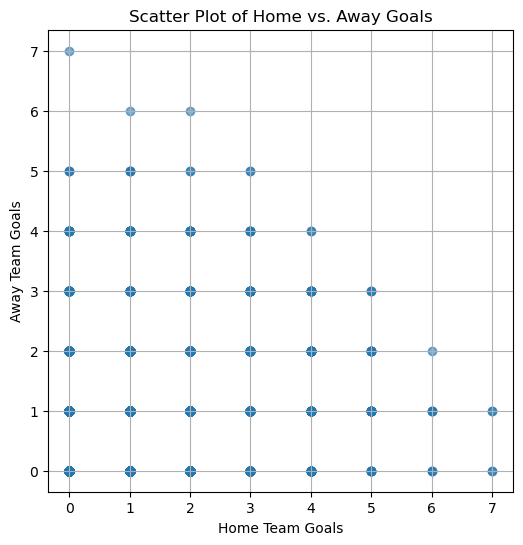

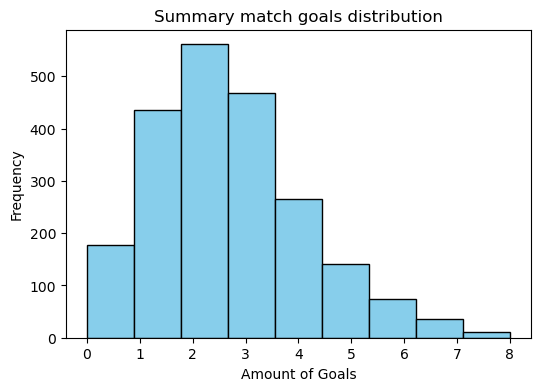

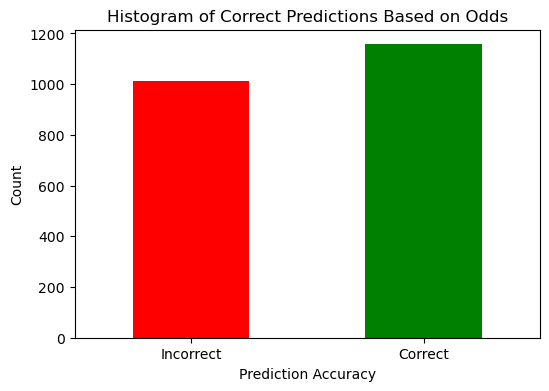

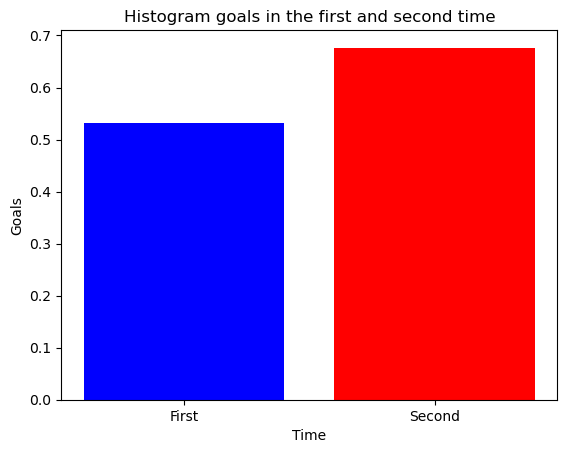

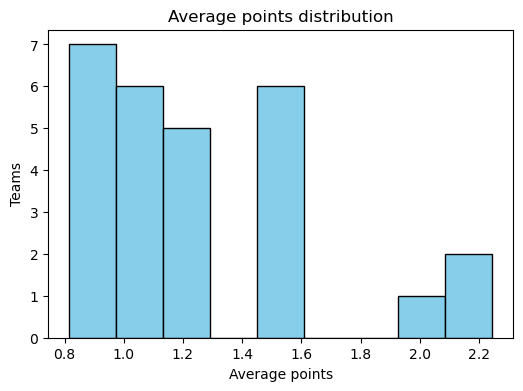

In [21]:
df_2 = spain_data.copy(deep=True)
draw_everything(df_2)

In [22]:
italy_urls = ['https://www.football-data.co.uk/mmz4281/1920/I1.csv', 'https://www.football-data.co.uk/mmz4281/2021/I1.csv', 'https://www.football-data.co.uk/mmz4281/2122/I1.csv',
             'https://www.football-data.co.uk/mmz4281/2223/I1.csv', 'https://www.football-data.co.uk/mmz4281/2324/I1.csv',
             'https://www.football-data.co.uk/mmz4281/2425/I1.csv']
italy_data = five_years_ligue_history(italy_urls)
italy_data

,date,time,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,first_half_home_goals,first_half_away_goals,first_half_result,...,fouls_away,corners_home,corners_away,yellow_cards_home,yellow_cards_away,red_cards_home,red_cards_away,max_odds_home_win,max_odds_draw,maximum_odds_away_win
0,2019-08-24,17:00,Parma,Juventus,0,1,A,0,1,A,...,14,5,8,2,3,0,0,12.00,5.50,1.35
1,2019-08-24,19:45,Fiorentina,Napoli,3,4,A,1,2,A,...,16,4,5,2,4,0,0,5.12,3.85,1.81
2,2019-08-25,17:00,Udinese,Milan,1,0,H,0,0,D,...,11,9,4,1,3,0,0,4.10,3.43,2.14
3,2019-08-25,19:45,Cagliari,Brescia,0,1,A,0,0,D,...,11,8,8,2,2,0,0,1.88,3.78,4.75
4,2019-08-25,19:45,Roma,Genoa,3,3,D,2,2,D,...,13,5,1,3,1,0,0,1.53,4.40,8.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2175,2025-03-09,11:30,Verona,Bologna,1,2,A,0,1,A,...,11,1,3,2,1,1,0,5.30,3.60,1.84
2176,2025-03-09,14:00,Napoli,Fiorentina,2,1,H,1,0,H,...,5,4,4,1,2,0,0,1.63,4.25,6.60
2177,2025-03-09,17:00,Empoli,Roma,0,1,A,0,1,A,...,10,1,9,0,0,0,0,4.08,3.60,2.07
2178,2025-03-09,19:45,Juventus,Atalanta,0,4,A,0,1,A,...,11,2,5,1,1,0,0,2.64,3.33,2.98


In [23]:
italy_data.isna().sum()
## пропуски в данных есть, данные числовые, так что заполним их средними значениями
#italy_data.fillna(italy_data.mean(), inplace=True)

date                     0
time                     0
home_team                0
away_team                0
full_time_home_goals     0
full_time_away_goals     0
full_time_result         0
first_half_home_goals    0
first_half_away_goals    0
first_half_result        0
home_shots               0
away_shots               0
home_target_shots        0
away_target_shots        0
fouls_home               0
fouls_away               0
corners_home             0
corners_away             0
yellow_cards_home        0
yellow_cards_away        0
red_cards_home           0
red_cards_away           0
max_odds_home_win        1
max_odds_draw            1
maximum_odds_away_win    1
dtype: int64

In [24]:
italy_data[['max_odds_home_win', 'max_odds_draw', 'maximum_odds_away_win']].fillna( \
        italy_data[['max_odds_home_win', 'max_odds_draw', 'maximum_odds_away_win']].mean(), inplace=True)

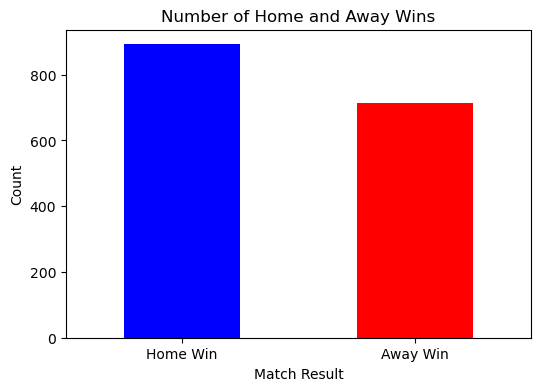

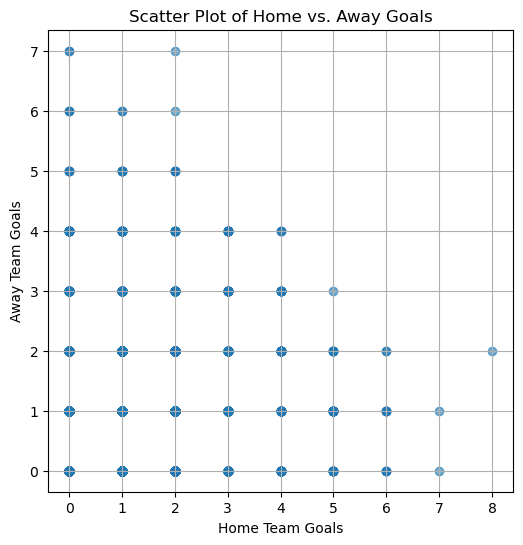

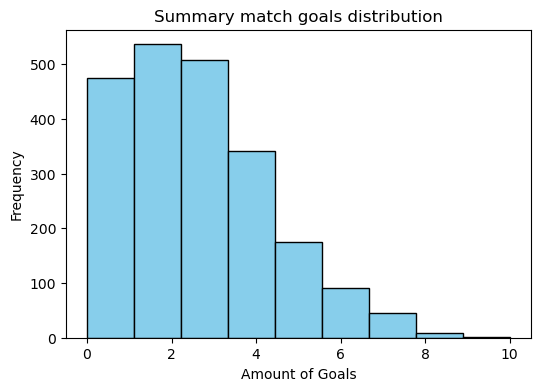

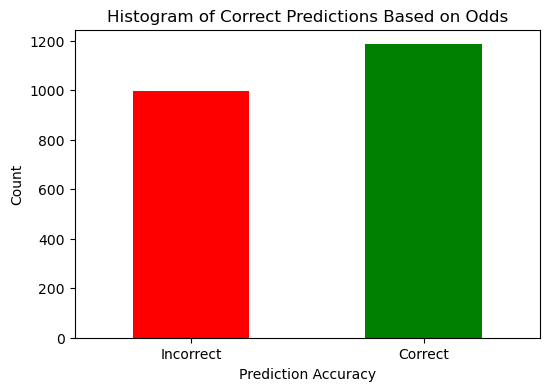

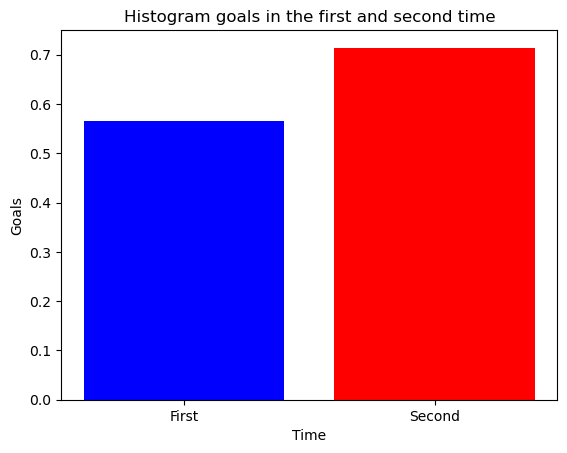

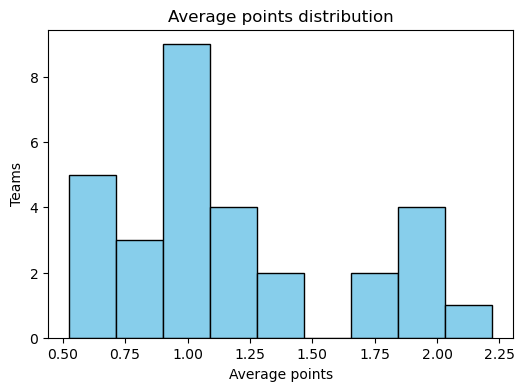

In [25]:
df_3 = italy_data.copy(deep=True)
draw_everything(df_3)

In [26]:
france_urls = ['https://www.football-data.co.uk/mmz4281/1920/F1.csv', 'https://www.football-data.co.uk/mmz4281/2021/F1.csv', 'https://www.football-data.co.uk/mmz4281/2122/F1.csv',
                'https://www.football-data.co.uk/mmz4281/2223/F1.csv', 'https://www.football-data.co.uk/mmz4281/2324/F1.csv',
                'https://www.football-data.co.uk/mmz4281/2425/F1.csv']
france_data = five_years_ligue_history(france_urls)
france_data

,date,time,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,first_half_home_goals,first_half_away_goals,first_half_result,...,fouls_away,corners_home,corners_away,yellow_cards_home,yellow_cards_away,red_cards_home,red_cards_away,max_odds_home_win,max_odds_draw,maximum_odds_away_win
0,2019-08-09,19:45,Monaco,Lyon,0,3,A,0,2,A,...,17,2,5,2,2,1,0,3.00,3.60,2.52
1,2019-08-10,16:30,Marseille,Reims,0,2,A,0,0,D,...,8,5,3,1,0,0,0,1.71,3.85,6.40
2,2019-08-10,19:00,Angers,Bordeaux,3,1,H,3,1,H,...,15,4,3,2,1,0,0,2.47,3.29,3.37
3,2019-08-10,19:00,Brest,Toulouse,1,1,D,1,0,H,...,14,4,7,0,0,0,0,2.46,3.42,3.22
4,2019-08-10,19:00,Dijon,St Etienne,1,2,A,1,2,A,...,10,12,5,0,2,0,0,4.00,3.46,2.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945,2025-03-09,14:00,Brest,Angers,2,0,H,1,0,H,...,8,6,6,1,1,0,0,1.80,3.92,5.00
1946,2025-03-09,16:15,Le Havre,St Etienne,1,1,D,1,1,D,...,17,5,6,2,3,0,0,2.40,3.74,3.10
1947,2025-03-09,16:15,Nantes,Strasbourg,0,1,A,0,0,D,...,17,3,9,1,1,0,0,2.68,3.52,2.83
1948,2025-03-09,16:15,Reims,Auxerre,0,2,A,0,2,A,...,13,6,12,1,1,0,0,2.55,3.52,3.01


In [27]:
france_data.isna().sum()
## пропусков в данных нет

date                     0
time                     0
home_team                0
away_team                0
full_time_home_goals     0
full_time_away_goals     0
full_time_result         0
first_half_home_goals    0
first_half_away_goals    0
first_half_result        0
home_shots               0
away_shots               0
home_target_shots        0
away_target_shots        0
fouls_home               0
fouls_away               0
corners_home             0
corners_away             0
yellow_cards_home        0
yellow_cards_away        0
red_cards_home           0
red_cards_away           0
max_odds_home_win        0
max_odds_draw            0
maximum_odds_away_win    0
dtype: int64

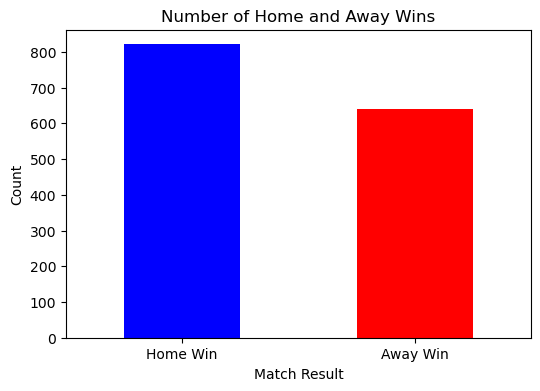

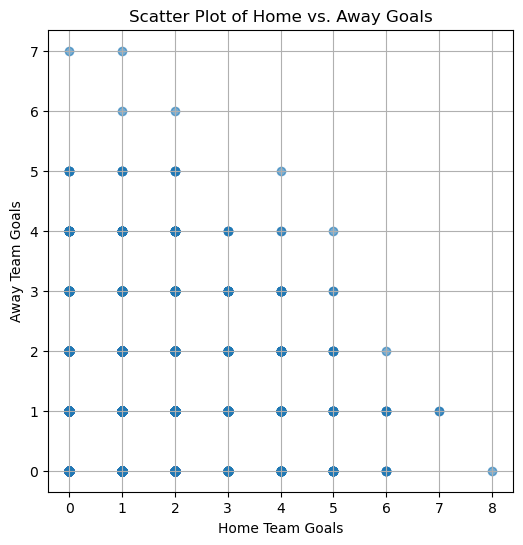

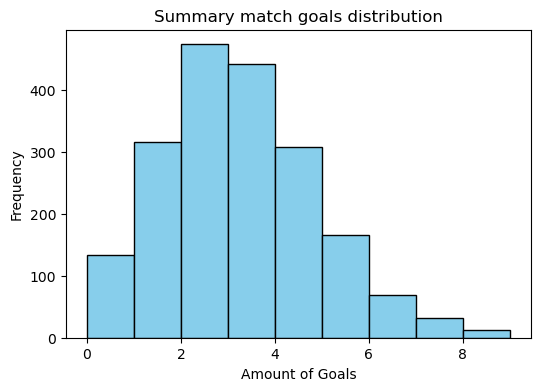

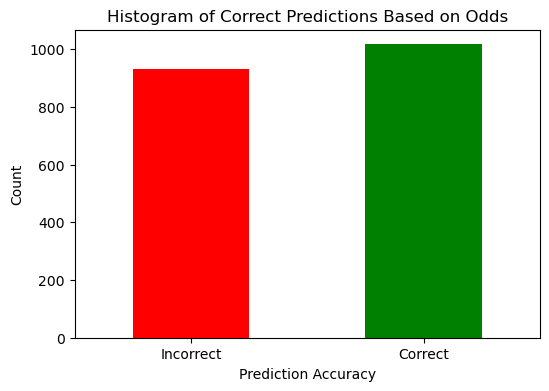

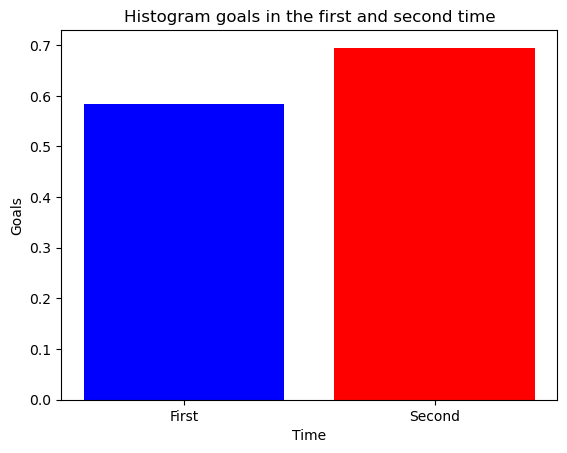

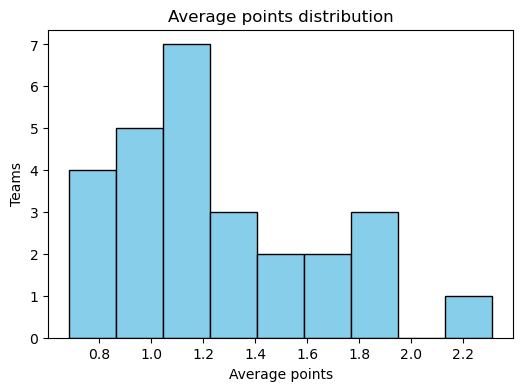

In [28]:
df_4 = france_data.copy(deep=True)
draw_everything(df_4)

## Проверка гипотез

{'whiskers': [<matplotlib.lines.Line2D at 0x1a16215e710>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1634504d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a16343acd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a163451510>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a163451d90>],
 'means': []}

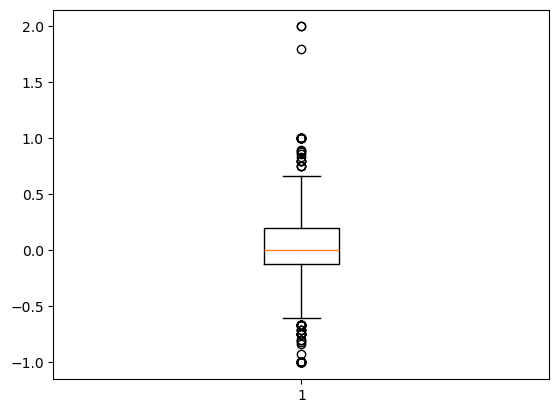

In [29]:
leagues = [eng_data, ger_data, spain_data, italy_data, france_data]

spain_realization_home, spain_realization_away = realization_ratio(spain_data)
dif_dist = spain_realization_home - spain_realization_away
plt.boxplot(dif_dist)

Выбросов уж больно много! Мы крайне этим огорчены. В среднем, конечно, ноль голов разницы, поэтому и соотношение оказывается нулевым. Либо результаты ничейные, и команды, собственно, одинаково все реализуют, поэтому все аналогично сводится в ноль.

Там есть странные ситуации, где соотношение > 1, это связано с автоголами, либо вызвано условностью правил, когда удар с пенальти не считается за удар в створ. Поэтому и происходит такое.

In [30]:
import pandas as pd
clubs = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQmFHAHNtBeIuSLX70t473XHQMEZBhZ-sptNC11lzvxrJgjZm0zIirfe7UtQT6CEumcrB7e4FHU0JAU/pub?output=csv')
clubs

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season,filename,url
0,105,sv-darmstadt-98,SV Darmstadt 98,L1,NaN,27,25.6,13,48.1,1,Merck-Stadion am Böllenfalltor,17810,+€3.05m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/sv-darmstadt-9...
1,11127,ural-ekaterinburg,Ural Yekaterinburg,RU1,NaN,30,26.5,11,36.7,3,Yekaterinburg Arena,23000,+€880k,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/ural-ekaterinb...
2,114,besiktas-istanbul,Beşiktaş Jimnastik Kulübü,TR1,NaN,30,26.5,15,50.0,8,Beşiktaş Park,42445,€-25.26m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/besiktas-istan...
3,12,as-rom,Associazione Sportiva Roma,IT1,NaN,26,26.2,18,69.2,17,Olimpico di Roma,70634,€-76.90m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/as-rom/startse...
4,148,tottenham-hotspur,Tottenham Hotspur Football Club,GB1,NaN,30,25.4,21,70.0,19,Tottenham Hotspur Stadium,62850,€-120.05m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/tottenham-hots...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,724,fc-volendam,FC Volendam,NL1,NaN,25,23.4,6,24.0,2,Kras Stadion,7384,+€800k,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/fc-volendam/st...
435,800,atalanta-bergamo,Atalanta Bergamasca Calcio S.p.a.,IT1,NaN,26,27.6,14,53.8,20,Gewiss Stadium,24950,+€11.45m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/atalanta-berga...
436,85465,karpaty-lviv-2020-,FK Karpaty Lviv,UKR1,NaN,29,25.6,7,24.1,2,Ukraina,28051,€-3.28m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/karpaty-lviv-2...
437,979,moreirense-fc,Moreirense Futebol Clube,PO1,NaN,27,26.0,17,63.0,3,Estádio C. J. de Almeida Freitas,6150,+€2.60m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/moreirense-fc/...


In [31]:
players = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vShQmF6Mdy9cvKmckh0kQq2w-ZEGrb5nDeupjNFVzyHRYwuX9jqrd96-KvPIiRLlNKuMGVSLyh0qkGF/pub?output=csv')
players

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,...,right,184.0,NaN,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,...,left,190.0,NaN,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,750000.0,8000000.0
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,...,NaN,NaN,NaN,CSKA-AS-23 Ltd.,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dimitar-berbat...,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0
3,77,NaN,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,...,NaN,NaN,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lucio/profil/s...,IT1,Juventus Football Club,200000.0,24500000.0
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,...,right,194.0,NaN,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tom-starke/pro...,L1,FC Bayern München,100000.0,3000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32581,1364960,Darryl,Nkulikiyimana,Darryl Nkulikiyimana,2024,9010,darryl-nkulikiyimana,NaN,NaN,Belgium,...,left,NaN,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/darryl-nkuliki...,BE1,FC Verbroedering Denderhoutem Denderleeuw Eend...,NaN,NaN
32582,1365020,Afonso,Assis,Afonso Assis,2024,979,afonso-assis,NaN,NaN,Portugal,...,left,NaN,2025-06-30 0:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/afonso-assis/p...,PO1,Moreirense Futebol Clube,NaN,NaN
32583,1367128,Abdoulaye,Yoro,Abdoulaye Yoro,2024,6890,abdoulaye-yoro,NaN,NaN,Cote d'Ivoire,...,left,175.0,2027-06-30 0:00:00,Tamegnon Consulting,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/abdoulaye-yoro...,TR1,İstanbul Başakşehir Futbol Kulübü,NaN,NaN
32584,1369057,Yusuf,Kurt,Yusuf Kurt,2024,11282,yusuf-kurt,Türkiye,Batman,Türkiye,...,left,186.0,2025-06-30 0:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/yusuf-kurt/pro...,TR1,Alanyaspor,NaN,NaN


In [32]:
players = players.merge(clubs, left_on='current_club_id', right_on ='club_id')
ligue_names = {'Italy':'IT1', 'Germany': 'L1', 'England': 'GB1', 'France': 'FR1', 'Spain': 'ES1'}
players[(players['domestic_competition_id'] == ligue_names['Italy']) & (players['last_season_x'] == 2024)]
def find_ligue_players_price(ligue_name):
    ligue_players_price = players[(players['domestic_competition_id'] == ligue_names[ligue_name]) & (players['last_season_x'] == 2024)]
    ligue_players_price.reset_index(inplace=True, drop=True)
    return ligue_players_price

def find_players_price(ligue_name):
    ligue_players_price = find_ligue_players_price(ligue_name)
    ligue_clubs_price = ligue_players_price.groupby(by=['current_club_name'], as_index=False).agg({'market_value_in_eur':'sum'})
    ligue_clubs_price['market_value_in_eur'] = ligue_clubs_price['market_value_in_eur'].astype('int32')
    return ligue_clubs_price
italy_players_price = find_ligue_players_price('Italy')
italy_clubs_price = find_players_price('Italy')
ger_players_price = find_ligue_players_price('Germany')
ger_clubs_price = find_players_price('Germany')
france_players_price = find_ligue_players_price('France')
france_clubs_price = find_players_price('France')
eng_players_price = find_ligue_players_price('England')
eng_clubs_price = find_players_price('England')
spain_players_price = find_ligue_players_price('Spain')
spain_clubs_price = find_players_price('Spain')

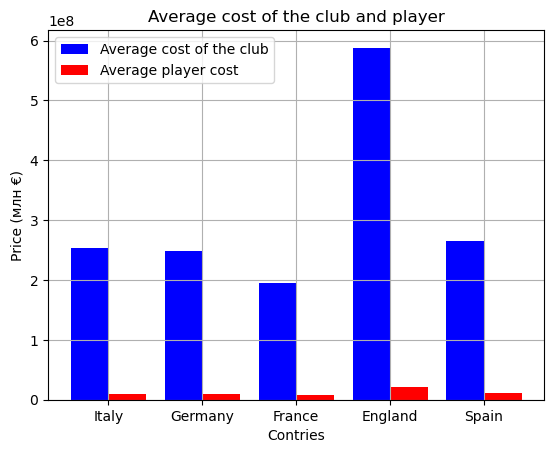

In [33]:
countries = ["Italy", "Germany", "France", "England", "Spain"]
club_value = [italy_clubs_price["market_value_in_eur"].mean(), ger_clubs_price["market_value_in_eur"].mean(), france_clubs_price["market_value_in_eur"].mean(), eng_clubs_price["market_value_in_eur"].mean(), spain_clubs_price["market_value_in_eur"].mean()]
player_value = [italy_players_price["market_value_in_eur"].mean(), ger_players_price["market_value_in_eur"].mean(), france_players_price["market_value_in_eur"].mean(), eng_players_price["market_value_in_eur"].mean(), spain_players_price["market_value_in_eur"].mean()]


x = np.arange(len(countries))
width = 0.4


fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, club_value, width, label="Average cost of the club", color="blue")
bars2 = ax.bar(x + width/2, player_value, width, label="Average player cost", color="red")

ax.set_xlabel("Contries")
ax.set_ylabel("Price (млн €)")
ax.set_title("Average cost of the club and player")
ax.set_xticks(x)
ax.set_xticklabels(countries)
ax.legend()
ax.grid(True)  # Добавляем сетку для удобства


plt.show()

## Проверка гипотезы: команды в Английской лиге выигрывают чаще дома, чем в гостях (без учета ничьих)
Нулевая гипотеза: p_home = p_away = 0.5  
Альтернативная гипотеза: p_home > p_away



In [34]:
win_home = (eng_data['full_time_result'] == 'H').astype('int32')
win_away = (eng_data['full_time_result'] == 'A').astype('int32')
win_home

0       1
1       0
2       0
3       1
4       0
       ..
2176    0
2177    1
2178    0
2179    0
2180    0
Name: full_time_result, Length: 2181, dtype: int32

In [35]:
# Z-тест для пропорций (без учета ничьих)
total_matches_with_result = win_home.sum() + win_away.sum()  # матчи с победой
successes = win_home.sum()  # домашние победы

# Нулевая гипотеза: p_home = p_away = 0.5

z_stat, p_value = proportions_ztest(
    count=successes, nobs=total_matches_with_result,value=0.5,
    alternative='larger'  # проверяем, что p_home > 0.5
)

print(f"Z-тест (без ничьих):\nZ-статистика = {z_stat:.2f}, p-value = {p_value:.5f}\n")

alpha = 0.05
if p_value < alpha:
    print("- Z-тест: домашние победы статистически значимо чаще (p < 0.05)")
else:
    print("- Z-тест: нет значимой разницы")

Z-тест (без ничьих):
Z-статистика = 5.44, p-value = 0.00000

- Z-тест: домашние победы статистически значимо чаще (p < 0.05)


Любопытное (хоть и довольно ожидаемое!) наблюдение. К сожалению, причину этого мы уже раскрыть вряд ли сможем: то ли психология домашнего стадиона, и позориться перед любимыми болельщиками нельзя, то ли на родной поляне травка мягче и зеленее... Но точно понятно, что это значимый фактор.

Другое дело, что мы конечно наглеем, когда пытаемся называть данную ситуацию нормальным распределением, а величины могут часто оказываться вообще-то зависимыми (особенно уж в футболе), но иногда нужно сделать грубое допущение.

## Проверка гипотезы: распределение домашних побед, ничьих и гостевых побед равномерно
Нулевая гипотеза: p_home = p_away = p_draw = $\frac{1}{3}$   
Альтернативная гипотеза: p_home != p_away != p_draw

In [36]:
# Хи-квадрат тест (с учетом ничьих)
observed = eng_data['full_time_result'].value_counts().values
expected = [len(eng_data) / 3] * 3  # ожидаемые значения при равномерном распределении

chi2_stat, p_value_chi, _, _ = chi2_contingency([observed, expected])

print(f"Хи-квадрат тест (все исходы):\nχ² = {chi2_stat:.2f}, p-value = {p_value_chi:.5f}")

if p_value_chi < alpha:
    print("- Хи-квадрат: распределение исходов не равномерно (p < 0.05)")
else:
    print("- Хи-квадрат: распределение близко к равномерному")

Хи-квадрат тест (все исходы):
χ² = 70.85, p-value = 0.00000
- Хи-квадрат: распределение исходов не равномерно (p < 0.05)


Продолжая предыдущую гипотезу, мы можем заметить, что все далеко от равномерного распределения. Это здесь и проверяется. Так что, опять же, равномерно поставить и равномерно выиграть не получится. Получится равномерно проиграть. А это плохо.

К тому же, мы не учитываем уровень команд. Они могут выигрывать везде. И даже их уровень, скорее всего, неравномерно распределен по лиге, иначе бы тут это нам ничего не подпортило.  
  
    
<center><img src="https://i.pinimg.com/736x/b8/aa/06/b8aa060c089b252d804704f06fde2496.jpg" width="500"></center>

## Проверка гипотезы: Команды реализуют голевые моменты в Испании дома лучше, чем в гостях
Нулевая гипотеза: conv_home = conv_away   
Альтернативная гипотеза:  conv_home > conv_away


In [37]:
#Парный t-тест (зависимые выборки)
t_stat, p_value = ttest_rel(spain_realization_home, spain_realization_away)

print(f"Результаты парного t-теста:")
print(f"t-статистика = {t_stat:.2f}, p-value = {p_value:.4f}")

# Размер эффекта (Cohen's d)
d = (spain_realization_home.mean() - spain_realization_away.mean()) / np.sqrt(
    (spain_realization_home.std()**2 + spain_realization_away.std()**2) / 2
)
print(f"\nCohen's d = {d}")

Результаты парного t-теста:
t-статистика = 1.97, p-value = 0.0493

Cohen's d = 0.06021459063782326


У нас маленький эффект! Различие статистически значимо, да, но что-то не сильно им все можно объяснить. Судя по всему, факторов уж больно много. И это, конечно, круто. Нет, ну вы представьте, какой ужас был бы, если бы все самое интересное только на домашних матчах было бы? И кто бы тогда смотрел футбол по телевизору... В общем, эффект не так уж и велик, как нам хотелось бы.

## Машинное обучение

In [38]:
def make_datasets_for_ml(some_data, home_team, away_team, some_coefs):
    """возвращает тренировочный датасет и датасет с реальными данными для предсказания"""
    history_between_clubs = find_2clubs_confr_history(some_data, home_team, away_team)

    target = history_between_clubs['full_time_result']

    home_results, last_match_home = find_results_5_matches(some_data, home_team)
    away_results, last_match_away = find_results_5_matches(some_data, away_team)

    full_data = history_between_clubs.merge(home_results, on='date').merge(away_results, on='date')
    train_data = full_data[['home_team', 'away_team', 'full_time_result', 'max_odds_home_win', 'max_odds_draw', 'maximum_odds_away_win', 'sum_goals_5_x', 'sum_points_5_x', 'sum_goals_5_y', 'sum_points_5_y']]
    train_data = train_data.rename(columns={'sum_goals_5_x' : 'sum_goals_5_home', 'sum_points_5_x': 'sum_points_5_home', 'sum_goals_5_y': 'sum_goals_5_away', 'sum_points_5_y': 'sum_points_5_away'})
    train_data['is_cur_home_team_home'] = train_data['home_team'] == home_team


    match_coef = some_coefs[(some_coefs['team1'] == home_team) & (some_coefs['team2'] == away_team)]
    to_predict = train_data[0:0]
    to_predict['home_team'] = match_coef['team1']
    to_predict['away_team'] = match_coef['team2']
    to_predict['max_odds_home_win'] = match_coef['team1_odds']
    to_predict['max_odds_draw'] =  match_coef['draw_odds']
    to_predict['maximum_odds_away_win'] = match_coef['team2_odds']
    to_predict['sum_goals_5_home'] = last_match_home['sum_goals_5'].values[0]
    to_predict['sum_points_5_home'] = last_match_home['sum_points_5'].values[0]
    to_predict['sum_goals_5_away'] = last_match_away['sum_goals_5'].values[0]
    to_predict['sum_points_5_away'] = last_match_away['sum_points_5'].values[0]
    to_predict['is_cur_home_team_home'] = True
    to_predict

    return train_data, to_predict

<center><img src="https://pictures.ua.tribuna.com/image/0e7b9890-fc02-4061-a21e-7d4de78346ca?width=1260&quality=70" width="500"></center>

In [59]:
def return_prediction(some_data, home_team, away_team, some_coefs):
    """обучает логистискую регрессию и возвращает ожидаемую прибыль за матч"""
    data, to_predict = make_datasets_for_ml(some_data, home_team, away_team, some_coefs)
    if len(data) < 8: ## нет смысла ставить(команды недавно появились в лиге)
        return 0, 'никого'
    train, test = data[:-2], data[-2:]


    y_test, x_test = test['full_time_result'], test.drop(['home_team', 'away_team', 'full_time_result'], axis=1)
    y_train, x_train = train['full_time_result'], train.drop(['home_team', 'away_team', 'full_time_result'], axis=1)
    best_c = 0.00001
    max_acc = 0
    ## делаем модель с регуляризацией(данных мало) и проверяем коэфы регуляризации
    for c in [0.001, 0.005, 0.01, 0.15, 0.1, 0.5, 1, 2, 5, 10, 50]:

        model = Pipeline([('scaler', StandardScaler()),('clf', LogisticRegression(multi_class='multinomial',penalty='l2',C=c, class_weight='balanced'))])
        model.fit(x_train, y_train)
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        train_accuracy, test_accuracy = (y_train_pred == y_train).mean(), (y_test_pred == y_test).mean()

        if test_accuracy > max_acc:
            best_c = c
    ## предсказываем на реальных данных на лучшей модели
    best_model = Pipeline([('scaler', StandardScaler()),('clf', LogisticRegression(multi_class='multinomial',penalty='l2',C=best_c, class_weight='balanced'))])
    best_model.fit(x_train, y_train)

    probs = best_model.predict_proba(to_predict[['max_odds_home_win', 'max_odds_draw', 'maximum_odds_away_win', 'sum_goals_5_home', 'sum_points_5_home', 'sum_goals_5_away', 'sum_points_5_away', 'is_cur_home_team_home']])[0]
    if len(probs) < 3: ## нет ничьих или побед одной команды
        return 0, 'никого'
    game_profit = (probs * np.array(to_predict[['max_odds_home_win', 'max_odds_draw', 'maximum_odds_away_win']])).sum() - 1

    x = np.argmax(probs)
    if x == 0:
        to_bet = home_team
    elif x == 1:
        to_bet = 'draw'
    else:
        to_bet = away_team

    return game_profit, to_bet

In [61]:
def compare_ligue(some_data, some_coefs):
    for i in range(len(some_coefs)):
        try:
            home_team, away_team = some_coefs.iloc[i, 0], some_coefs.iloc[i, 1]
            profit, to_bet = return_prediction(some_data, home_team, away_team, some_coefs)
            print(f'ожидаемая прибыль на матч {home_team} - {away_team} составляет {profit}, ставим на {to_bet}')
        except IndexError or TypeError:
            continue

In [62]:
eng_coefs = pd.read_csv('eng_ligue_coefs.csv')
eng_coefs

,team1,team2,team1_odds,draw_odds,team2_odds
0,Arsenal,Chelsea,1.72,3.67,5.24
1,Fulham,Tottenham,1.85,3.91,4.05
2,Leicester,Manchester Utd,4.21,3.61,1.89
3,Arsenal,Fulham,1.43,4.42,7.80
4,Wolves,West Ham,2.32,3.33,3.11
5,Nottingham,Manchester Utd,2.18,3.57,3.15
6,Bournemouth,Ipswich,1.40,4.97,7.32
7,Brighton,Aston Villa,2.02,3.83,3.34
8,Manchester City,Leicester,1.17,7.95,13.88
9,Newcastle,Brentford,1.71,4.34,4.20


In [63]:
compare_ligue(eng_data, eng_coefs)

ожидаемая прибыль на матч Arsenal - Chelsea составляет 0.8819429200725497, ставим на Arsenal
ожидаемая прибыль на матч Fulham - Tottenham составляет 0, ставим на никого
ожидаемая прибыль на матч Arsenal - Fulham составляет 0, ставим на никого
ожидаемая прибыль на матч Wolves - West Ham составляет 0, ставим на никого
ожидаемая прибыль на матч Bournemouth - Ipswich составляет 0, ставим на никого
ожидаемая прибыль на матч Brighton - Aston Villa составляет 2.063345677726822, ставим на draw
ожидаемая прибыль на матч Newcastle - Brentford составляет 0, ставим на никого
ожидаемая прибыль на матч Southampton - Crystal Palace составляет 3.929999999482975, ставим на Southampton
ожидаемая прибыль на матч Liverpool - Everton составляет 8.673296640763613, ставим на Everton
ожидаемая прибыль на матч Chelsea - Tottenham составляет 3.0202623562910276, ставим на Tottenham
ожидаемая прибыль на матч Everton - Arsenal составляет 0.7753256874846814, ставим на Arsenal
ожидаемая прибыль на матч Crystal Palac